<a href="https://colab.research.google.com/github/fsacconeUBA/Mossbauer/blob/main/PyMossFit_V3_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Preparando para Colab e importando librerías necesarias.
"""
!pip install lmfit
from google.colab import drive
drive.mount('/content/drive/', force_remount= True)
img = '/content/drive/MyDrive/Colab-Notebooks/PyMossFit/MuestrasLuis/SSKFP_M23/4452.Asc'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lmfit import Parameters, minimize, fit_report
from scipy.constants import *
from scipy.integrate import trapz
from pathlib import Path

path= Path(img); name= path.stem; title= path.parent.name; full= path.parents[0]; print(name, title, full)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
Mounted at /content/drive/
4452 SSKFP_M23 /content/drive/MyDrive/Colab-Notebooks/PyMossFit/MuestrasLuis/SSKFP_M23


Ingrese la fecha de calibración (AAAAMMDD): 20240517
Ingrese el rango de V (en mm/s): 6.08


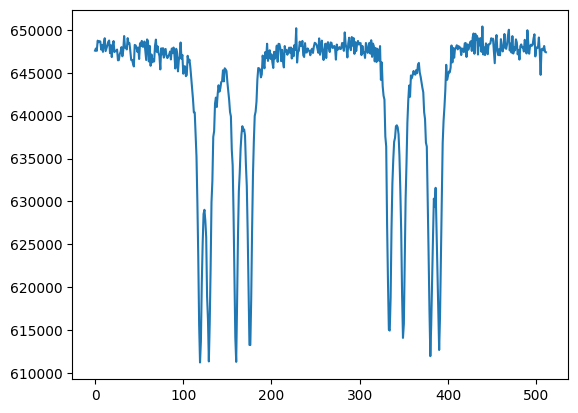

1295672


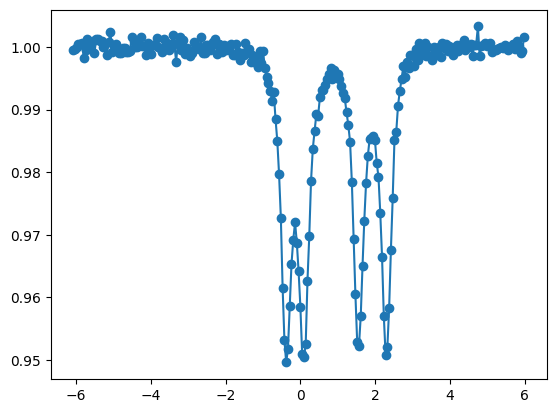

In [ ]:
"""
Para doblar, normalizar y calibrar en mm/s, los archivos del espectrómetro de CNEA de 512 canales
"""
fecha = str(input('Ingrese la fecha de calibración (AAAAMMDD): '),)
vel = float(input('Ingrese el rango de V (en mm/s): ' ), )

np.savetxt(f"{full}/{name}_calib.txt", (fecha,vel), fmt='%s')

y= np.loadtxt(img, delimiter=","); y=y[:,1]

plt.plot(y)
plt.show()

for i in range(0, 255):
    y[[i]]=y[[i]]+y[[511-i]]

y=y[0:255]

"""
Normalización
"""
y2= np.concatenate([y[4:44],y[200:254]])

ymax=np.mean(y2)
ymax=int(ymax)

print(ymax)

for i in range(0, 255):
    y[[i]]=y[[i]]/ymax

x=np.arange(1,256)

"""
de canales a escala de velocidades en mm/s
"""
v=np.loadtxt(f"{full}/{name}_calib.txt"); vmax=v[[1]]

x=np.linspace(start = 0, stop = 255, num= 256)

for i in range(0, 255):
    x[[i]]=(i-128)*vmax/128

x= x[0:255]

plt.plot(x,y, marker="o")
plt.show()

np.savetxt(f"{full}/{name}.csv", list(zip(x,y)), delimiter=",", fmt='%1.6f')


ancho1 (sigma1/sqrt(2)) es: 0.22 mm/s
Centroide1 (ISO1) es: 1.196 mm/s
Amplitud1 (a1) es: 0.0230
Doblete1 es: 2.207 mm/s
área1: 51.0 %
ancho2 (sigma2/sqrt(2)) es: 0.21 mm/s
Centroide2 (ISO2) es: 0.589 mm/s
Amplitud2 (a2) es: 0.0220
Doblete2 es: 1.933 mm/s
área2: 49.0 %
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 100
    # data points      = 255
    # variables        = 8
    chi-square         = 2.7559e-04
    reduced chi-square = 1.1158e-06
    Akaike info crit   = -3487.15225
    Bayesian info crit = -3458.82214
[[Variables]]
    b1:  0.30820969 +/- 0.00492487 (1.60%) (init = 0.35)
    m1:  1.19572573 +/- 0.00157718 (0.13%) (init = 1.3)
    d1:  2.20735833 +/- 0.00307376 (0.14%) (init = 2.9)
    a1:  0.02295450 +/- 2.8745e-04 (1.25%) (init = 0.1)
    b2:  0.29951925 +/- 0.00487391 (1.63%) (init = 0.35)
    m2:  0.58918014 +/- 0.00157494 (0.27%) (init = 0.6)
    d2:  1.93286256 +/- 0.00307236 (0.16%) (init = 2.2)
    a2:  0.02201407 +/- 2.8100e-0

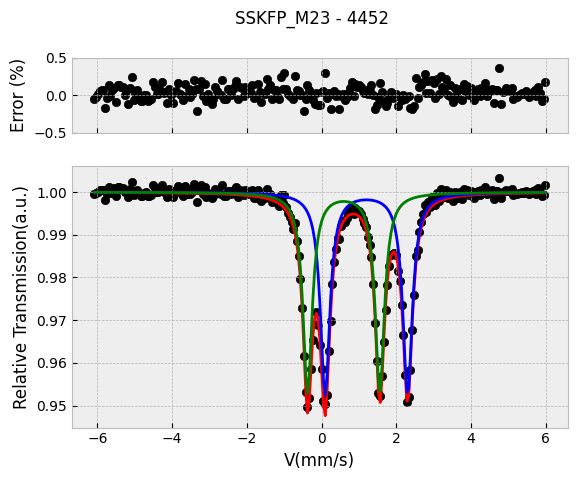

In [ ]:
"""
LECTURA DE ARCHIVO DE ENTRADA
"""
col_list=[0, 1]

x, y= np.loadtxt(f"{full}/{name}.csv", delimiter=",", usecols=col_list, unpack=True)

"""
DEFINICIÓN DE LAS FUNCIONES BASADAS EN LORENTZIANAS
"""
def singlet(a, b, m, x):
    return 2*a*b/(pi*(b**2+4*(x-m)**2))

def doublet(a, b, m, d, x):
    return 2*a*b/(pi*(b**2+4*(x-(m-d/2))**2))+2*a*b/(pi*(b**2+4*(x-(m+d/2))**2))

def sextet(a, b, m, d, q, l23, x):
    return 6*a*b/(pi*(b**2+4*(x-(m+5*d))**2))+l23*2*a*b/(pi*(b**2+4*(x-(m+3*d-q))**2))+2.5*a*b/(pi*(b**2+4*(x-(m+0.75*d))**2))+2.5*a*b/(pi*(b**2+4*(x-(m-0.75*d))**2))+l23*2*a*b/(pi*(b**2+4*(x-(m-3*d+q))**2))+6*a*b/(pi*(b**2+4*(x-(m-5*d))**2))

def linear_fitting_lmfit(params, x, y):
    b1= params['b1']; m1= params['m1']; d1= params['d1']; a1= params['a1']
    b2= params['b2']; m2= params['m2']; d2= params['d2']; a2= params['a2']

    y_fit= 1-(doublet(a1, b1, m1, d1, x))-(doublet(a2, b2, m2, d2, x))

    return y_fit-y

"""
AJUSTE DE LOS PARÁMETROS USANDO LOS DATOS EXPERIMENTALES
"""
params= Parameters()

params.add('b1', value= 0.35, vary=True)
params.add('m1', value= 1.3, vary=True)
params.add('d1', value= 2.9, vary=True)
params.add('a1', value= 0.1, vary=True)
params.add('b2', value= 0.35, vary=True)
params.add('m2', value= 0.6, vary=True)
params.add('d2', value= 2.2, vary=True)
params.add('a2', value= 0.08, vary=True)

fitted_params= minimize(linear_fitting_lmfit, params, args=(x, y,), method='least_square')

m1= fitted_params.params['m1'].value
b1= fitted_params.params['b1'].value
d1= fitted_params.params['d1'].value
a1= fitted_params.params['a1'].value
m2= fitted_params.params['m2'].value
b2= fitted_params.params['b2'].value
d2= fitted_params.params['d2'].value
a2= fitted_params.params['a2'].value

"""
CREACIÓN DE LOS SUBESPECTROS AJUSTADOS
"""
z= 1-(doublet(a1, b1, m1, d1, x))-(doublet(a2, b2, m2, d2, x))
z1= 1-(doublet(a1, b1, m1, d1, x))
z2= 1-(doublet(a2, b2, m2, d2, x))
e= (y-z)/y*100

"""
INTEGRAL DE ÁREAS Y GENERACIÓN DE LOS PARÁMETROS HIPERFINOS. REPORTE EN PANTALLA
"""
int1= trapz(1-z1, x); int2= trapz(1-z2, x)

b1= "{0:.2f}".format(b1/np.sqrt(2))
m1= "{0:.3f}".format(m1)
d1= "{0:.3f}".format(d1)
a1= "{0:.4f}".format(a1)
i1= "{0:.1f}".format(100*abs(int1/(int1+int2)))
b2= "{0:.2f}".format(b2/np.sqrt(2))
m2= "{0:.3f}".format(m2)
d2= "{0:.3f}".format(d2)
a2= "{0:.4f}".format(a2)
i2= "{0:.1f}".format(100*abs(int2/(int1+int2)))


print('ancho1 (sigma1/sqrt(2)) es:', b1, 'mm/s')
print('Centroide1 (ISO1) es:', m1, 'mm/s')
print('Amplitud1 (a1) es:', a1)
print('Doblete1 es:', d1, 'mm/s')
print('área1:', i1, '%')
print('ancho2 (sigma2/sqrt(2)) es:', b2, 'mm/s')
print('Centroide2 (ISO2) es:', m2, 'mm/s')
print('Amplitud2 (a2) es:', a2)
print('Doblete2 es:', d2, 'mm/s')
print('área2:', i2, '%')
print(fit_report(fitted_params))

"""
GRAFICA DE ESPECTROS Y SUBESPECTROS
"""
plt.style.use('bmh')

fig, (ax1, ax2) = plt.subplots(2, sharex=True, height_ratios=[1,3.5]); fig.suptitle(f"{title}" " - " f"{name}")
ax1.scatter (x, e, c= 'black')
ax1.set_ylim(-0.5,0.5)
ax1.set_ylabel('Error (%)')

ax2.scatter (x, y, c= 'black')
ax2.set_xlabel('V(mm/s)')
ax2.set_ylabel('Relative Transmission(a.u.)')
ax2.plot(x, z, c='red')
ax2.plot(x, z1, c='blue')
ax2.plot(x, z2, c='green')

plt.show()

"""
GENERACIÓN DE ARCHIVOS DE SALIDA: DATOS Y PARÁMETROS
"""
np.savetxt(f"{full}/{name}-plot.csv", list(zip(x,y, z, z1, z2)), fmt='%1.6e')

df= pd.DataFrame ({'Ancho(mm/s)': [b1, b2], 'ISO (mm/s)': [m1, m2], 'Quadrupolar shift': [d1, d2], 'Área(%)': [i1, i2]})
df.to_csv(f"{full}/{name}_report.csv", index=False)